# Jupyter Tutorial for Using SymPy to Produce an Nth-Order Pendulum

In [93]:
# Import Statements
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation, collections
% matplotlib inline

from pylab import *

from sympy import symbols, Dummy, lambdify
from sympy.physics.mechanics import *

from scipy.integrate import odeint

from random import randrange

from IPython.display import HTML

## The Following Code is for a Comprehensive Simulation of an Nth-Order Pendulum

In [79]:
def integrate_pendulum(N, time_vector, 
                       pos_init=235, vel_init=0, 
                       length_vector=None, 
                       mass_vector=1):
    q, u = dynamicsymbols("q:{0}".format(str(N))), dynamicsymbols("u:{0}".format(str(N)))
    m, l = symbols("m:{0}".format(str(N))), symbols("l:{0}".format(str(N)))
    g, t = symbols("g t")
    
    frame = ReferenceFrame("frame")
    point = Point("point")
    point.set_vel(frame, 0)
    particles, forces, kin_odes = list(), list(), list()
        
    for iterator in range(N):
        # Creates reference frame following each iterated mass
        frame_i = frame.orientnew("frame_{}".format(str(iterator)), "Axis", [q[iterator], frame.z])
        frame_i.set_ang_vel(frame, u[iterator] * frame.z)
        # frames.append(frame_i)

        point_i = point.locatenew("point_{}".format(str(iterator)), l[iterator] * frame_i.x)
        point_i.v2pt_theory(point, frame, frame_i)
        
        ref_point_i = Particle("ref_point_{}".format(str(iterator)), point_i, m[iterator])
        particles.append(ref_point_i)

        forces.append((point_i, m[iterator] * g * frame.x))
        kin_odes.append(q[iterator].diff(t) - u[iterator])
        point = point_i
        
    kane = KanesMethod(frame, q_ind=q, u_ind=u, kd_eqs=kin_odes)
    fr, frstar = kane.kanes_equations(particles, forces)

    # Numerical Integration
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(pos_init, N), 
                                    np.broadcast_to(vel_init, N)]))
    
    if length_vector is None:
        length_vector = np.ones(N) / N
    length_vector, mass_vector = np.broadcast_to(length_vector, N), np.broadcast_to(mass_vector, N)
    
    params = [g] + list(l) + list(m)
    param_vals = [9.81] + list(length_vector) + list(mass_vector)
    
    dummy_params = [Dummy() for iterator in q + u]
    dummy_dict = dict(zip(q + u, dummy_params))
    
    kin_diff_dict = kane.kindiffdict()
    mass_matrix = kane.mass_matrix_full.subs(kin_diff_dict).subs(dummy_dict)
    full_forcing_vector = kane.forcing_full.subs(kin_diff_dict).subs(dummy_dict)
    
    mm_func = lambdify(dummy_params + params, mass_matrix)
    ff_func = lambdify(dummy_params + params, full_forcing_vector)
    
    def parametric_gradient_function(y, t, args):
        """ Global function to derive 1st-order equations of motion from parametric arguments. """
        values = np.concatenate((y, args))
        solutions = np.linalg.solve(mm_func(*values), ff_func(*values))
        return np.array(solutions).T[0]
    
    return odeint(parametric_gradient_function, y0, time_vector, args=(param_vals,))

In [80]:
def visualize_timewise_displacement(N, time_vector, ap_vector):
    fig, ax = subplots(2, sharex=True, sharey=False)
    fig.set_size_inches(6.5, 6.5)

    for iterator in range(N):
        ax[0].plot(time_vector, ap_vector[:, iterator], label="$q_{}$".format(iterator))
        ax[1].plot(time_vector, ap_vector[:, iterator + N], label="$u_{}$".format(iterator))

    ax[0].legend(loc=0)
    ax[1].legend(loc=0)
    ax[1].set_xlabel("Time (s)")
    ax[0].set_ylabel("Angle (rad)")
    ax[1].set_ylabel("Angular rate (rad/s)")

    fig.subplots_adjust(hspace=0)
    setp(ax[0].get_xticklabels(), visible=False)
    tight_layout()
    show()

In [81]:
def get_xy_displacement(ap_vector, length_vector=None, viz=False):
    """Get (x, y) coordinates from generalized coordinates p"""
    ap_vector = np.atleast_2d(ap_vector)
    n = ap_vector.shape[1] // 2
    
    if length_vector is None:
        length_vector = np.ones(n) / n
        
    zeros_vector = np.zeros(ap_vector.shape[0])[:, None]
    x = np.hstack([zeros_vector, length_vector * np.sin(ap_vector[:, :n])])
    y = np.hstack([zeros_vector, -length_vector * np.cos(ap_vector[:, :n])])
    
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    
    if viz is False:
        return np.cumsum(x, 1), np.cumsum(y, 1)
    else:
        plt.plot(np.cumsum(x, 1), np.cumsum(y, 1))
        return

### Visualizing XY Displacement of All N Pendulums

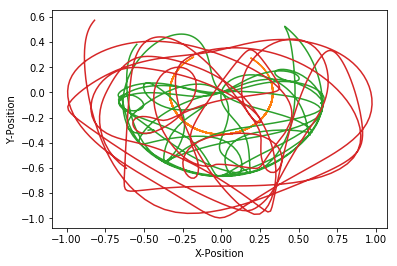

In [82]:
N, time_vector = 3, np.linspace(0, 10, 1000)
ap_vector = integrate_pendulum(N=N, time_vector=time_vector)
get_xy_displacement(ap_vector=ap_vector, viz=True)

### Visualizing Position-by-Time of All N Pendulums

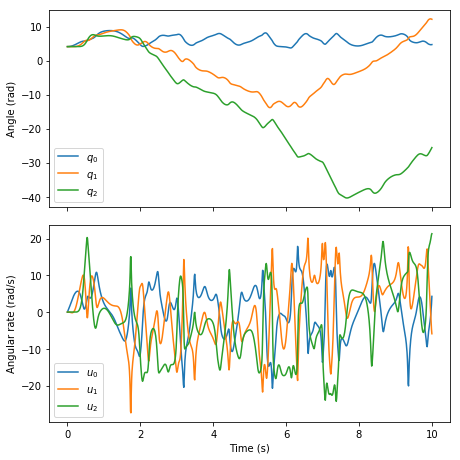

In [119]:
N, time_vector = 3, np.linspace(0, 10, 1000)
ap_vector = integrate_pendulum(N=N, time_vector=time_vector)
visualize_timewise_displacement(N=N, time_vector=time_vector, ap_vector=ap_vector)

### Visualizing the Nth-Order Pendulum Animation

In [107]:
def animate_nth_order_pendulum(N, tracer_length=None):
    start_pos, time_vector = randrange(120, 240, 1), np.linspace(0, 10, 1000)
    ap_vector = integrate_pendulum(N=N, time_vector=time_vector, pos_init=start_pos)
    x, y = get_xy_displacement(ap_vector)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis("off")
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    line, = ax.plot(list(), list(), "o-", lw=2)
    
    def _init_():
        line.set_data(list, list)
        return line,
    
    def animate_(iterator):
        line.set_data(x[iterator], y[iterator])
        return line,
                        
    anim_obj = animation.FuncAnimation(fig, animate_, frames=len(time_vector),
                                       interval=1000 * time_vector.max() / len(time_vector),
                                       blit=True, init_func=_init_)
    plt.close(fig)
    return anim_obj

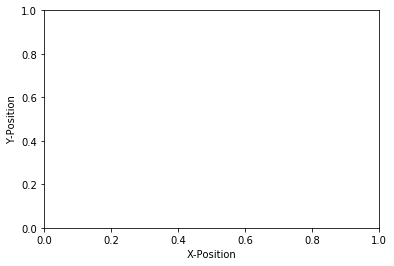

In [111]:
N = 3
anim_obj = animate_nth_order_pendulum(N=N)

curr_anim_loc = "animations/single/pendulum_model_order-{}_single.mp4".format(N)
anim_obj.save(curr_anim_loc)
HTML('<video controls loop src={} />'.format(curr_anim_loc))

In [114]:
def animate_multiple_pendulums_with_tracers(N, number_of_pendulums=12, perturbation=1E-6, tracer_length=15):
    oversample = 3
    tracer_length *= oversample
    
    time_vector = np.linspace(0, 10, oversample * 200)
    ap_vector = [integrate_pendulum(N, time_vector, pos_init=135 + iterator * perturbation / number_of_pendulums)
                for iterator in range(number_of_pendulums)]
    pos_vector = np.array([get_xy_displacement(pos) for pos in ap_vector])
    pos_vector = pos_vector.transpose(0, 2, 3, 1)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    tracer_segments = np.zeros((number_of_pendulums, 0, 2))
    tracer_collection = collections.LineCollection(tracer_segments, cmap="rainbow")
    tracer_collection.set_array(np.linspace(0, 1, number_of_pendulums))
    ax.add_collection(tracer_collection)
    
    points, = plt.plot(list(), list(), "ok")
    
    pendulum_segments = np.zeros((number_of_pendulums, 0, 2))
    pendulum_collection = collections.LineCollection(pendulum_segments, colors="black")
    ax.add_collection(pendulum_collection)
    
    def _init_():
        pendulum_collection.set_segments(np.zeros((number_of_pendulums, 0, 2)))
        tracer_collection.set_segments(np.zeros((number_of_pendulums, 0, 2)))
        points.set_data(list(), list())
        return pendulum_collection, tracer_collection, points
    
    def animate_(iterator):
        iterator *= oversample
        pendulum_collection.set_segments(pos_vector[:, iterator])
        tracer_slice = slice(max(0, iterator - tracer_length), iterator)
        tracer_collection.set_segments(pos_vector[:, tracer_slice, -1])
        x, y = pos_vector[:, iterator].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulum_collection, tracer_collection, points
    
    interval = 1000 * oversample * time_vector.max() / len(time_vector)
    anim_obj = animation.FuncAnimation(fig, animate_, frames=len(time_vector) // oversample,
                                   interval=interval,
                                   blit=True, init_func=_init_)
    
    plt.close(fig)
    return anim_obj

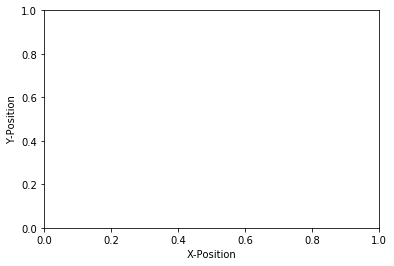

In [118]:
N, number_of_pendulums, perturbation = 3, 5, 10
anim_obj = animate_multiple_pendulums_with_tracers(N=N, number_of_pendulums=number_of_pendulums, perturbation=perturbation)

curr_anim_loc = "animations/many/pendulum_model_order-{}_many.mp4".format(N)
anim_obj.save(curr_anim_loc)
HTML('<video controls loop src={} />'.format(curr_anim_loc))

In [ ]:
HTML('<video c')